In [120]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine, delete, Table, MetaData
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
from matplotlib import font_manager
from matplotlib.ticker import MultipleLocator
matplotlib.rcdefaults()

In [2]:
DB_PARAMS = {
    'dbname': 'postgres',   # Replace with your database name
    'user': 'postgres',         # Replace with your PostgreSQL user
    'password': 'xxxxx', # Replace with your PostgreSQL password
    'host': 'localhost',         # PostgreSQL server host
    'port': '5432'               # Default port for PostgreSQL
}

In [3]:
def read_sql(query):
# Read SQL to DataFrame
        conn = psycopg2.connect(**DB_PARAMS)
        df = pd.read_sql_query(query, conn)
        conn.close()
        return df

In [16]:
accu_path =  "/Users/tpminh/Downloads/Roboto,Roboto_Mono/Roboto/static/Roboto-Regular.ttf"
font_manager.fontManager.addfont(accu_path)

## **We can start looking at number of address and its balance overtime**

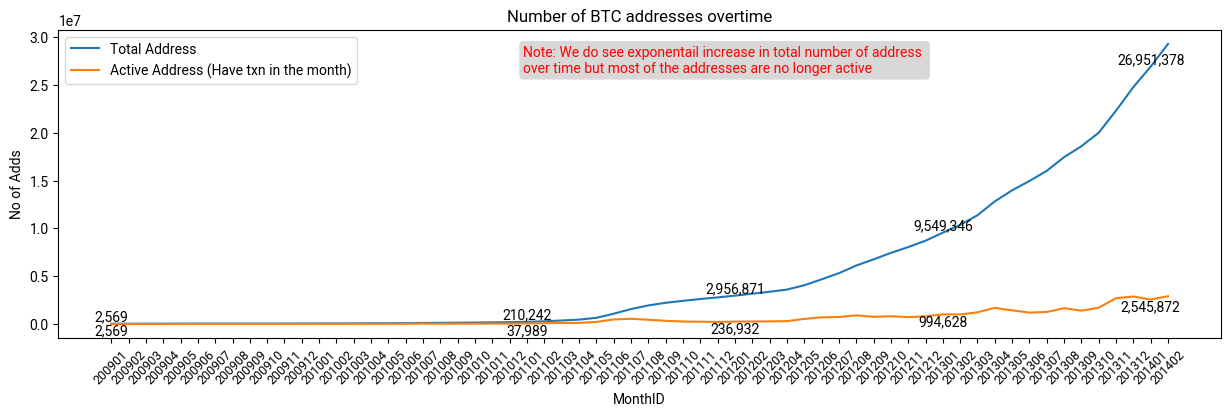

In [67]:
#df = read_sql('select count(*) total_address, count(case when count_outflow_cm + count_inflow_cm > 0 then addresses end ) active_address , month_id::text from fact_address_snapshot_monthly group by month_id order by month_id')
matplotlib.rcParams['font.family'] = 'Roboto' 
plt.figure(figsize=(15, 4))
ax = sns.lineplot(data = df, x = 'month_id', y = 'total_address', label='Total Address' )
ax2 = sns.lineplot(data = df, x = 'month_id', y = 'active_address',label='Active Address (Have txn in the month)'  )
plt.xticks(rotation=45, fontsize=9)
plt.title('Number of BTC addresses overtime')
plt.xlabel('MonthID')
plt.ylabel('No of Adds')
for i, row in df[df['month_id'].isin(['200901', '201101','201201','201301','201401']) ].iterrows():
    ax.text(x=row['month_id'], y=row['total_address'], s=f'{row["total_address"]:,}', color='black', ha='center', va='bottom')
for i, row in df[df['month_id'].isin(['200901', '201101','201201','201301','201401']) ].iterrows():
    ax2.text(x=row['month_id'], y=row['active_address'], s=f'{row["active_address"]:,}', color='black', ha='center', va='top')
plt.legend(loc='upper left')

text = ("Note: We do see exponentail increase in total number of address \n"
        "over time but most of the addresses are no longer active")

plt.text(0.4, 0.95, text, fontsize= 10, color='red'
            ,transform = plt.gca().transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,ha='left', va='top'
            )
        
plt.show()

/var/folders/np/yjbf57612_30_mjbr_d794yh0000gn/T/ipykernel_70541/352506468.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


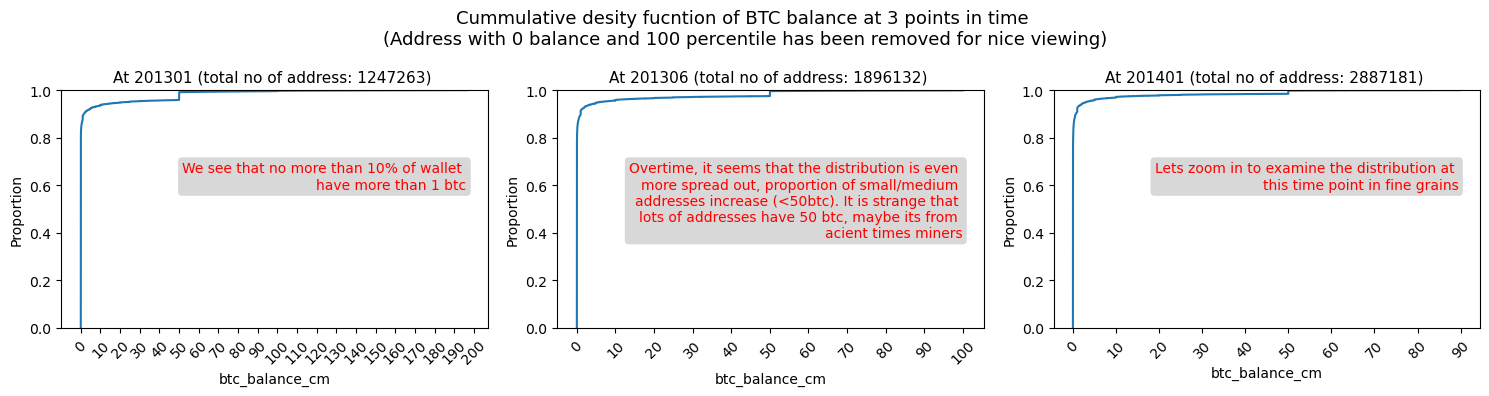

In [221]:
df_add = read_sql( 'select month_id,btc_balance_cm,percentile_rank from minhtp_test_percentile where percentile_rank <=0.99' )
fig, axes = plt.subplots(1,3,figsize = (15,4) )
axes = axes.flatten()
for ax, month in zip(axes,[201301,201306,201401]):
    sns.ecdfplot(df_add[df_add['month_id'] == month ], x = 'btc_balance_cm', ax = ax)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    no_add =len(df_add[df_add['month_id'] == month])
    ax.set_title(f'At {month} (total no of address: {no_add}) ', fontsize = 11)
    ax.tick_params(axis='x', rotation=45) 
plt.suptitle('Cummulative desity fucntion of BTC balance at 3 points in time \n'
             '(Address with 0 balance and 100 percentile has been removed for nice viewing)'
             , fontsize = 13)

axes[0].text(0.95,0.7,'We see that no more than 10% of wallet \n' 
                        'have more than 1 btc'
            ,transform=axes[0].transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='right', va='top'
            )

axes[1].text(0.95,0.7,'Overtime, it seems that the distribution is even \n'
                       'more spread out, proportion of small/medium \n' 
                        'addresses increase (<50btc). It is strange that \n' 
                        'lots of addresses have 50 btc, maybe its from \n' 
                         'acient times miners' 
            ,transform=axes[1].transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='right', va='top'
            )

axes[2].text(0.95,0.7,'Lets zoom in to examine the distribution at \n' 
                         'this time point in fine grains' 
            ,transform=axes[2].transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='right', va='top'
            )

plt.tight_layout()
plt.show()

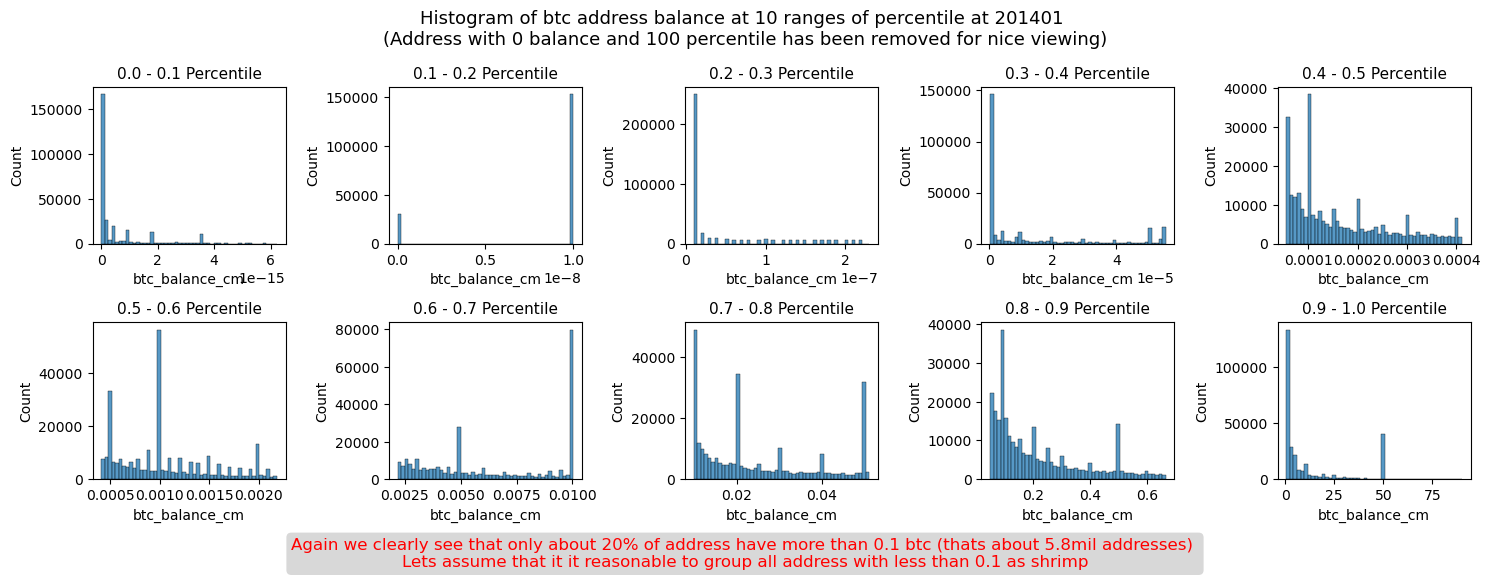

In [222]:
#percentile_range =  [(i/10,(i+2)/10) for i in range(0,10,2) ]
percentile_range =  [(i/10,(i+1)/10) for i in range(0,10,1) ]
fig,axes = plt.subplots(2,5, figsize = (15,6))
axes = axes.flatten()
for ax, (lower,upper)  in zip (axes , percentile_range):
    data_filtered = df_add[(df_add['month_id'] == 201401) & (df_add['percentile_rank'] >= lower ) & (df_add['percentile_rank'] < upper)]
    sns.histplot(data_filtered, x = 'btc_balance_cm', ax =ax, bins = 50 )
    ax.set_title(f'{lower:.1f} - {upper:.1f} Percentile' , fontsize = 11 )    
plt.subplots_adjust(bottom=0.1) 
comment = ('Again we clearly see that only about 20% of address have more than 0.1 btc (thats about 5.8mil addresses) \n'
                      'Lets assume that it it reasonable to group all address with less than 0.1 as shrimp')
fig.text(0.5, 0.1,comment,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red', va = 'top', ha = 'center', fontsize = 12)
plt.suptitle('Histogram of btc address balance at 10 ranges of percentile at 201401 \n'
             '(Address with 0 balance and 100 percentile has been removed for nice viewing)'
            ,fontsize = 13)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()

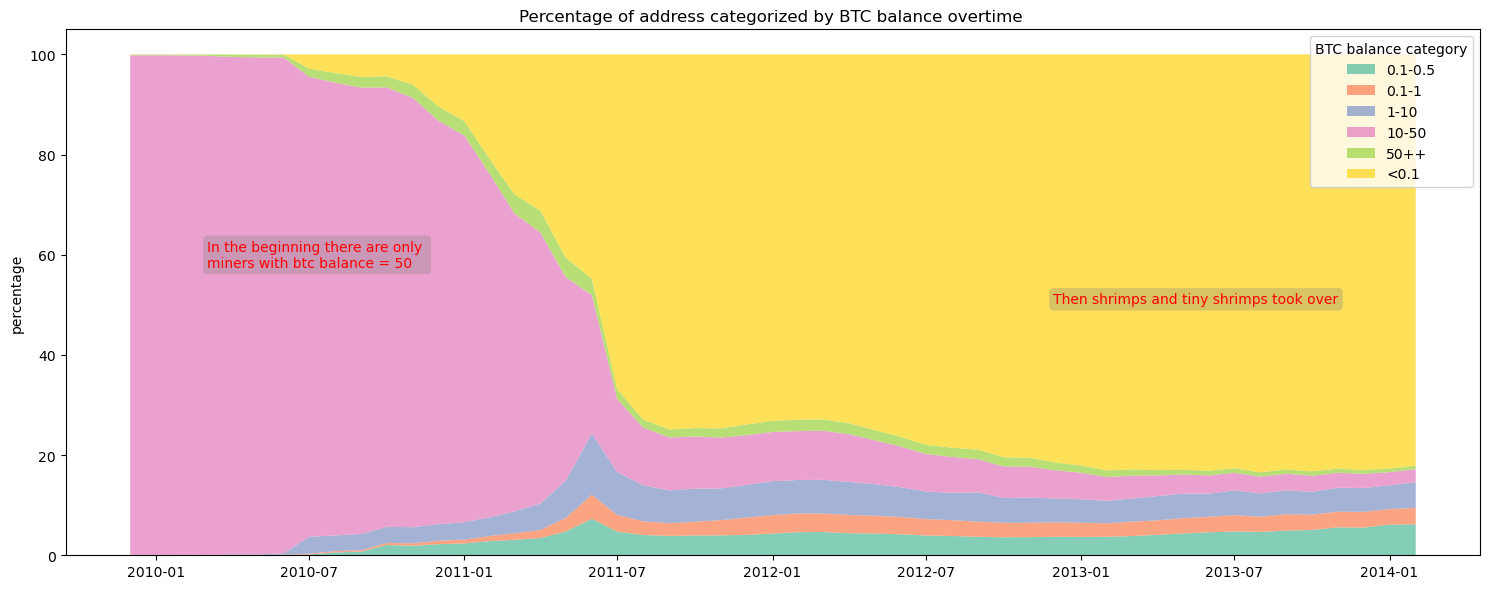

In [223]:
#df_btc_cate = read_sql("""select balance_cate,to_date(month_id::text ,'YYYYMM') timeid  ,count_add from test_btc_balance_cate""" )
#df_btc_cate_gb = df_btc_cate.groupby(['timeid','balance_cate']).sum().reset_index()
#df_btc_cate_gb_pv = df_btc_cate_gb.pivot(index="timeid", columns="balance_cate", values="count_add")
#df_btc_cate_gb_pv =  df_btc_cate_gb_pv.div(df_btc_cate_gb_pv.sum(axis=1), axis=0) * 100

plt.figure(figsize=(15, 6))
plt.stackplot(
    df_btc_cate_gb_pv.index,
    df_btc_cate_gb_pv.T,
    labels=df_btc_cate_gb_pv.columns,
    colors=sns.color_palette("Set2", len(df_btc_cate['balance_cate'].unique())),
    alpha=0.8,
)

plt.text(0.1,0.6,('In the beginning there are only \n' 
                    'miners with btc balance = 50')
            ,transform = plt.gca().transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='left', va='top'
            )

plt.text(0.9,0.5,('Then shrimps and tiny shrimps took over')
            ,transform = plt.gca().transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='right', va='top'
            )


plt.legend(title = 'BTC balance category', loc = 'upper right')
plt.title('Percentage of address categorized by BTC balance overtime ')
plt.ylabel('percentage')
plt.tight_layout()
plt.show()



## **Now lets have a look at miner balance**

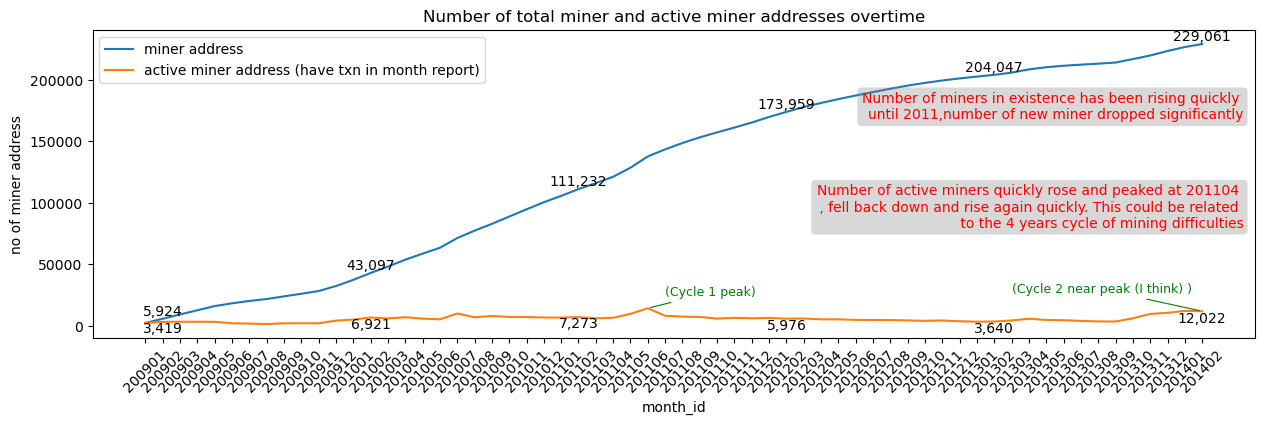

In [224]:
#df_miner = read_sql('select count(case when miner_flag = 1 then addresses end) miner_address, count(case when count_outflow_cm + count_inflow_cm > 0 and miner_flag = 1 then addresses end ) active_miner_address , month_id::text from fact_address_snapshot_monthly group by month_id order by month_id')

plt.figure(figsize = (15,4))
ax = sns.lineplot(data =  df_miner , x = 'month_id', y ='miner_address' , label = 'miner address')
ax1 = sns.lineplot(data =  df_miner , x = 'month_id', y ='active_miner_address'  , label = 'active miner address (have txn in month report)' )

for i, row in df_miner[df_miner['month_id'].isin(['200902','201002','201102','201202','201302','201402' ]) ].iterrows():
    ax.text(x = row['month_id'] , y = row['miner_address'],  s= f'{row["miner_address"]:,}' , ha = 'center', va = 'bottom', color = 'black' )
    ax1.text(x = row['month_id'] , y = row['active_miner_address'],  s= f'{row["active_miner_address"]:,}' , ha = 'center', va = 'top', color = 'black' )


plt.text(0.99,0.8,('Number of miners in existence has been rising quickly \n' 
                   'until 2011,number of new miner dropped significantly' )
                    ,ha = 'right', va = 'top'
                    ,transform = plt.gca().transAxes
                    ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
                     , color = 'red' , fontsize = 10
        )

plt.text(0.99,0.5,('Number of active miners quickly rose and peaked at 201104 \n '
                    ', fell back down and rise again quickly. This could be related \n '
                   'to the 4 years cycle of mining difficulties'  )
                    ,ha = 'right', va = 'top'
                    ,transform = plt.gca().transAxes
                    ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
                     , color = 'red' , fontsize = 10
        )
plt.annotate(
    f'(Cycle 1 peak)',  # Annotation text
    xy=(29, max(df_miner[df_miner['month_id'] == '201106']['active_miner_address']) ), # Point to annotate
    xytext=(29 + 1, max(df_miner[df_miner['month_id'] == '201106']['active_miner_address'])  + 10000),  # Text position
    arrowprops=dict(arrowstyle='-', color='green', lw=0.8),  # Minimal arrow
    fontsize=9,
    color='green'
)

        
plt.annotate(
    f'(Cycle 2 near peak (I think) )',  # Annotation text
    xy=(61, max(df_miner[df_miner['month_id'] == '201402']['active_miner_address']) ), # Point to annotate
    xytext=(50 , max(df_miner[df_miner['month_id'] == '201402']['active_miner_address'])  + 15000),  # Text position
    arrowprops=dict(arrowstyle='-', color='green', lw=0.8),  # Minimal arrow
    fontsize=9,
    color='green'
)



plt.ylabel('no of miner address')
plt.xticks(rotation =45)
plt.legend(loc = 'upper left')
plt.title('Number of total miner and active miner addresses overtime')
plt.show()



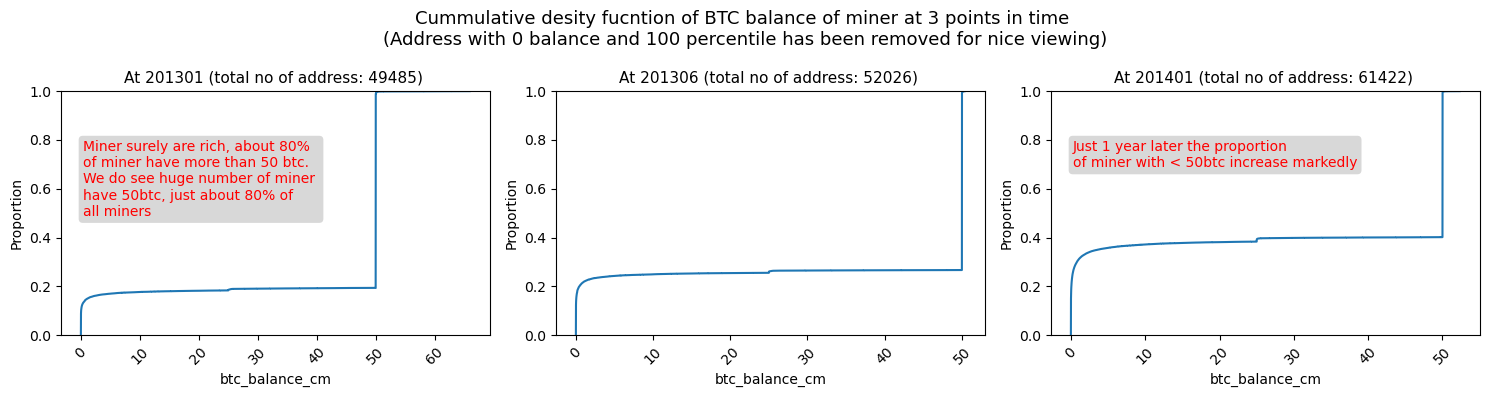

In [225]:
#df_miner_p = read_sql( 'select month_id,btc_balance_cm,percentile_rank from minhtp_test_percentile_miner where percentile_rank <=0.99' )
fig, axes = plt.subplots(1,3,figsize = (15,4) )
axes = axes.flatten()
for ax, month in zip(axes,[201301,201306,201401]):
    sns.ecdfplot(df_miner_p[df_miner_p['month_id'] == month ], x = 'btc_balance_cm', ax = ax)
    ax.xaxis.set_major_locator(MultipleLocator(10))
    no_add =len(df_miner_p[df_miner_p['month_id'] == month])
    ax.set_title(f'At {month} (total no of address: {no_add}) ', fontsize = 11)
    ax.tick_params(axis='x', rotation=45) 
plt.suptitle('Cummulative desity fucntion of BTC balance of miner at 3 points in time \n'
             '(Address with 0 balance and 100 percentile has been removed for nice viewing)'
             , fontsize = 13)

axes[0].text(0.05,0.8,('Miner surely are rich, about 80% \n' 
             'of miner have more than 50 btc.\n'  
             'We do see huge number of miner \n' 
             'have 50btc, just about 80% of \n' 
             'all miners')
            ,transform=axes[0].transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='left', va='top'
            )

axes[2].text(0.05,0.8,('Just 1 year later the proportion \n'
                        'of miner with < 50btc increase markedly' )
            ,transform=axes[2].transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='left', va='top'
            )


plt.tight_layout()
plt.show()



## **Now we analyse some attributes about btc transactions**

/var/folders/np/yjbf57612_30_mjbr_d794yh0000gn/T/ipykernel_70541/352506468.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


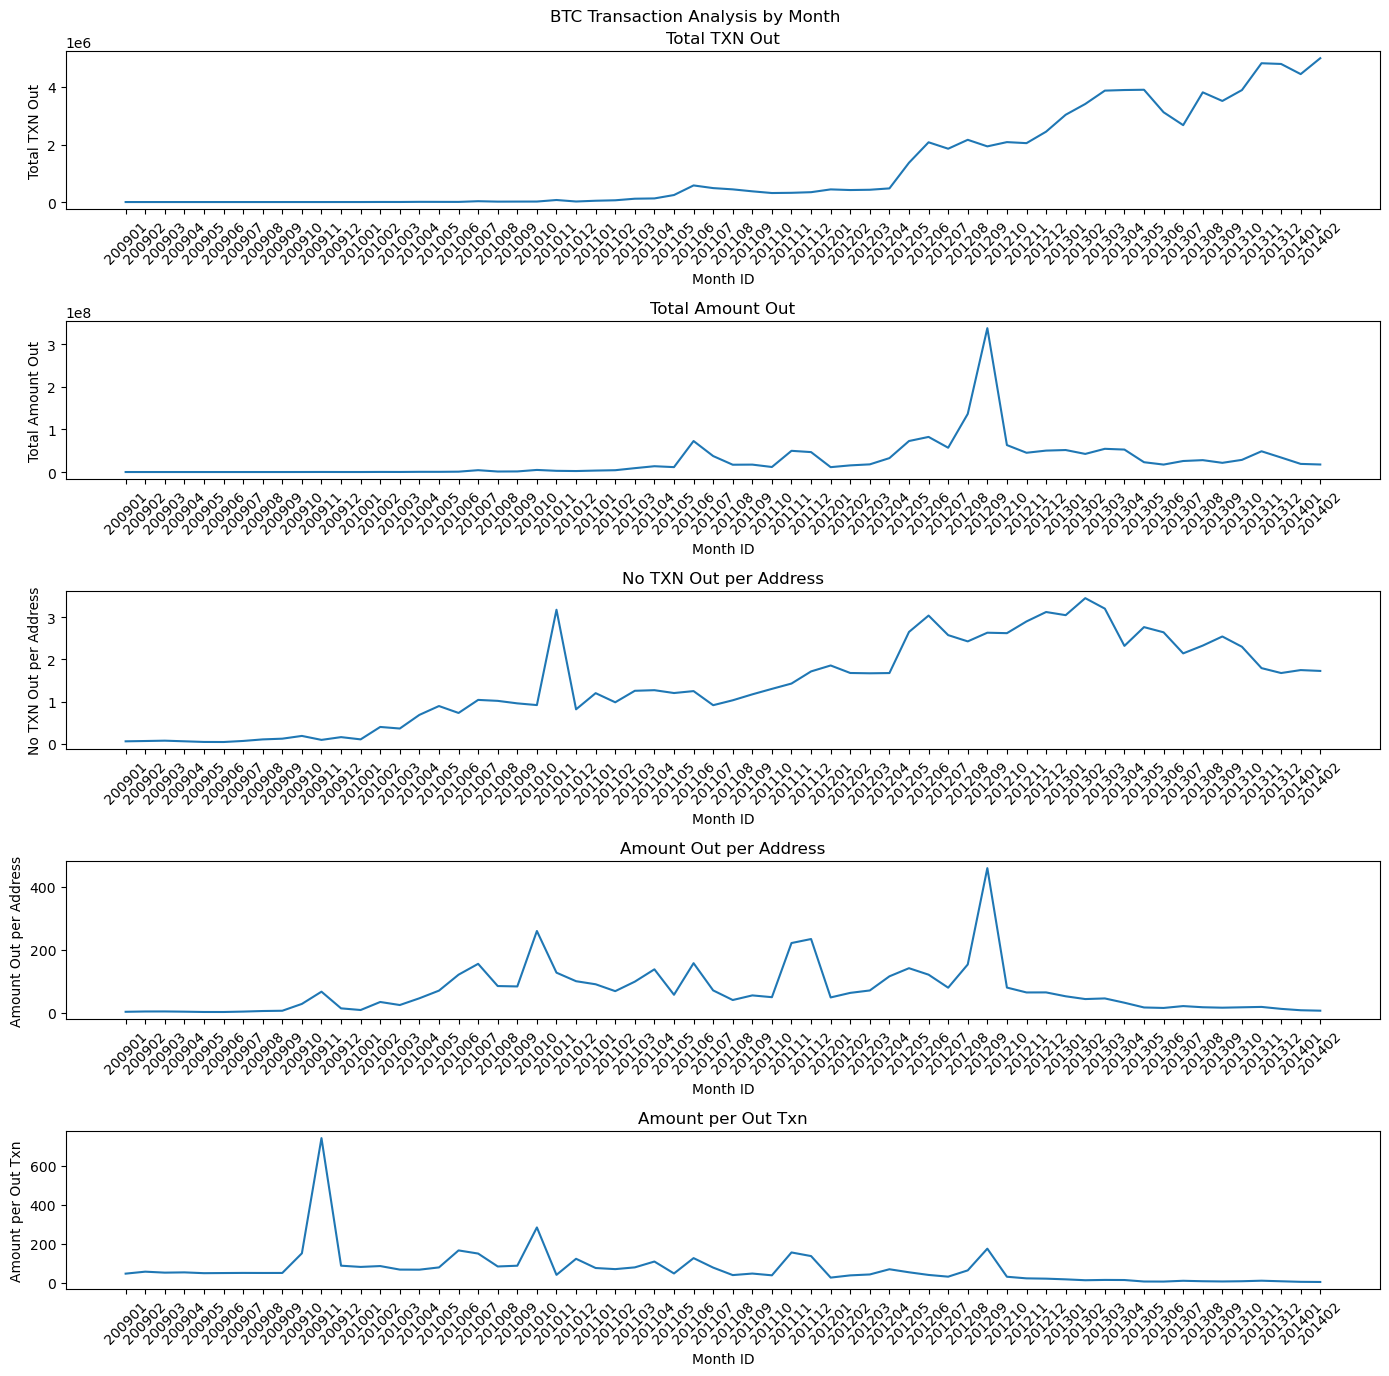

In [227]:
df = read_sql('''select 
sum(count_outflow_cm) total_txn_out
,sum(sum_outflow_cm) total_amt_out
,sum(sum_outflow_cm)/sum(count_outflow_cm) amt_per_txn
,sum(count_outflow_cm)/count(case when count_outflow_cm + count_inflow_cm > 0 then addresses end ) txn_out_per_add
,sum(sum_outflow_cm)/count(case when count_outflow_cm + count_inflow_cm > 0 then addresses end ) amt_out_per_add
,month_id::text 
from fact_address_snapshot_monthly
group by month_id 
 ''')

fig, axes = plt.subplots(5, 1, figsize=(14, 14))

axes = axes.flatten()

sns.lineplot(data=df, x='month_id', y='total_txn_out', ax=axes[0])
axes[0].set_title('Total TXN Out')
axes[0].set_xlabel('Month ID')
axes[0].set_ylabel('Total TXN Out')
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# Plot total_amt_out vs month_id
sns.lineplot(data=df, x='month_id', y='total_amt_out', ax=axes[1])
axes[1].set_title('Total Amount Out')
axes[1].set_xlabel('Month ID')
axes[1].set_ylabel('Total Amount Out')
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# Plot txn_out_per_add vs month_id
sns.lineplot(data=df, x='month_id', y='txn_out_per_add', ax=axes[2])
axes[2].set_title('No TXN Out per Address')
axes[2].set_xlabel('Month ID')
axes[2].set_ylabel('No TXN Out per Address')
axes[2].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# Plot amt_out_per_add vs month_id
sns.lineplot(data=df, x='month_id', y='amt_out_per_add', ax=axes[3])
axes[3].set_title('Amount Out per Address')
axes[3].set_xlabel('Month ID')
axes[3].set_ylabel('Amount Out per Address')
axes[3].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

# Plot amt per txn vs month_id
sns.lineplot(data=df, x='month_id', y='amt_per_txn', ax=axes[4])
axes[4].set_title('Amount per Out Txn')
axes[4].set_xlabel('Month ID')
axes[4].set_ylabel('Amount per Out Txn')
axes[4].tick_params(axis='x', rotation=45)  # Rotate x-axis ticks

plt.suptitle('BTC Transaction Analysis by Month' , fontsize=12)

plt.tight_layout()

plt.subplots_adjust(top=0.95)


In [18]:
query =  """
with cte as (
select 
count(case when count_inflow_cm > 0 and month_onchain <> 0 then count_inflow_cm end) count_month_in
,count(case when count_outflow_cm > 0 and month_onchain <> 0 then count_outflow_cm end) count_month_out
,addresses
from fact_address_snapshot_monthly  where 
month_id between  201308 and 201401
group by addresses
)
select 
count(addresses ) count_add
,count_month_in
,count_month_out
from cte
group by 
count_month_in
,count_month_out
"""



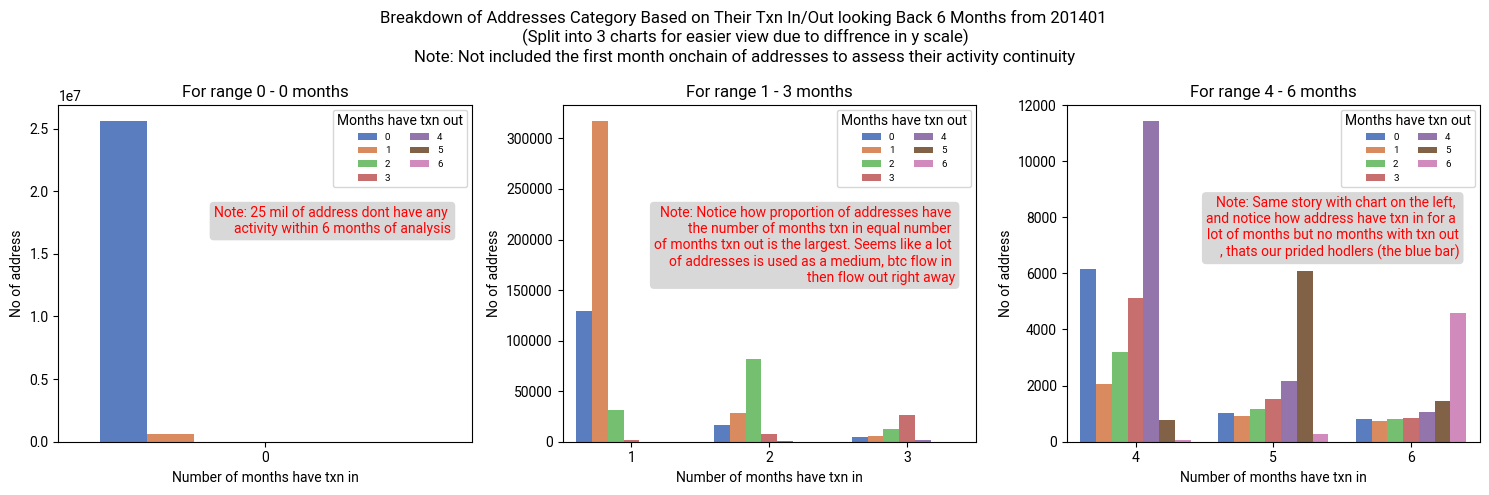

In [81]:
#df_inout_cate = read_sql(query)

fig, axes = plt.subplots(1,3, figsize= (15,5))
range_txn = [[0], [1,2,3], [4,5,6]]
axes = axes.flatten()
for ax,range_txn in zip(axes,range_txn) :
    sns.barplot(x = 'count_month_in' , y = 'count_add' , hue = 'count_month_out'
                , data = df_inout_cate[df_inout_cate['count_month_in'].isin(range_txn)] 
                , ax = ax, palette = 'muted'
                )
    ax.set_title(f'For range {min(range_txn)} - {max(range_txn)} months')
    ax.set_xlabel('Number of months have txn in')
    ax.set_ylabel('No of address')
    ax.legend(
    title='Months have txn out',
    loc='upper right',
    ncol=2,  # Arrange legend items in 2 columns
    fontsize=7
    )
plt.suptitle('Breakdown of Addresses Category Based on Their Txn In/Out looking Back 6 Months from 201401 \n'
            '(Split into 3 charts for easier view due to diffrence in y scale)\n'
            'Note: Not included the first month onchain of addresses to assess their activity continuity')

axes[0].text(0.95,0.7,"Note: 25 mil of address dont have any \n"
                      "activity within 6 months of analysis"
            ,transform=axes[0].transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='right', va='top'
            )
axes[1].text(0.95,0.7,'Note: Notice how proportion of addresses have \n' 
                      'the number of months txn in equal number \n' 
                      'of months txn out is the largest. Seems like a lot \n' 
                      'of addresses is used as a medium, btc flow in \n' 
                      'then flow out right away'
            ,transform=axes[1].transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='right', va='top'
            )

axes[2].text(0.95,0.73,'Note: Same story with chart on the left, \n' 
                    'and notice how address have txn in for a \n' 
                    'lot of months but no months with txn out\n' 
                    ', thats our prided hodlers (the blue bar)'
            ,transform=axes[2].transAxes
            ,bbox=dict(facecolor='grey', alpha=0.3, boxstyle='round',edgecolor='none')
            ,color = 'red'
            ,ha='right', va='top'
            )

plt.tight_layout()
plt.show()


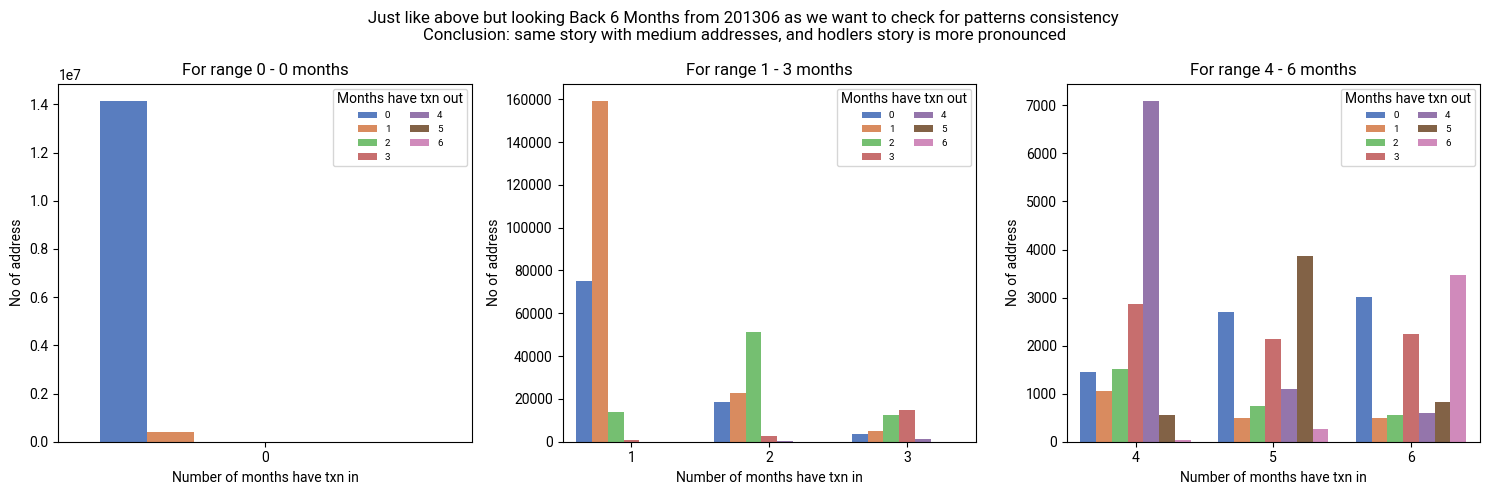

In [85]:
#df_inout_cate_2 = read_sql(query)

fig, axes = plt.subplots(1,3, figsize= (15,5))
range_txn = [[0], [1,2,3], [4,5,6]]
axes = axes.flatten()
for ax,range_txn in zip(axes,range_txn) :
    sns.barplot(x = 'count_month_in' , y = 'count_add' , hue = 'count_month_out'
                , data = df_inout_cate_2[df_inout_cate_2['count_month_in'].isin(range_txn)] 
                , ax = ax, palette = 'muted'
                )
    ax.set_title(f'For range {min(range_txn)} - {max(range_txn)} months')
    ax.set_xlabel('Number of months have txn in')
    ax.set_ylabel('No of address')
    ax.legend(
    title='Months have txn out',
    loc='upper right',
    ncol=2,  # Arrange legend items in 2 columns
    fontsize=7
    )
plt.suptitle('Just like above but looking Back 6 Months from 201306 as we want to check for patterns consistency \n'
            'Conclusion: same story with medium addresses, and hodlers story is more pronounced'
            )

plt.tight_layout()
plt.show()